In [1]:
import numpy as np

from auto_robot_design.description.builder import jps_graph2pinocchio_robot
from auto_robot_design.pinokla.default_traj import convert_x_y_to_6d_traj_xz, get_simple_spline, get_vertical_trajectory, create_simple_step_trajectory, get_workspace_trajectory
from auto_robot_design.optimization.problems import get_optimizing_joints
from auto_robot_design.optimization.saver import (
    ProblemSaver, )
from auto_robot_design.generator.restricted_generator.two_link_generator import TwoLinkGenerator, visualize_constrains
from auto_robot_design.description.builder import jps_graph2pinocchio_robot
from auto_robot_design.description.utils import draw_joint_point
from auto_robot_design.optimization.problems import CalculateCriteriaProblemByWeigths, get_optimizing_joints, CalculateMultiCriteriaProblem
from auto_robot_design.optimization.optimizer import PymooOptimizer
from auto_robot_design.pinokla.calc_criterion import ActuatedMass, EffectiveInertiaCompute, ImfCompute, ManipCompute, MovmentSurface, NeutralPoseMass, TranslationErrorMSE, ManipJacobian
from auto_robot_design.pinokla.criterion_agregator import CriteriaAggregator
from auto_robot_design.pinokla.criterion_math import ImfProjections
from auto_robot_design.pinokla.default_traj import get_steped_round_step_adjustable_trajectory, get_steped_round_trajectory, convert_x_y_to_6d_traj_xz, get_simple_spline, get_vertical_trajectory, create_simple_step_trajectory,get_workspace_trajectory,get_horizontal_trajectory
from auto_robot_design.optimization.rewards.reward_base import PositioningReward, PositioningConstrain, PositioningErrorCalculator, RewardManager
from auto_robot_design.optimization.rewards.jacobian_and_inertia_rewards import HeavyLiftingReward, AccelerationCapability, MeanHeavyLiftingReward, MinAccelerationCapability
from auto_robot_design.optimization.rewards.pure_jacobian_rewards import EndPointZRRReward, VelocityReward, ForceEllipsoidReward, ZRRReward, MinForceReward,MinManipulabilityReward
from auto_robot_design.optimization.rewards.inertia_rewards import MassReward
from auto_robot_design.description.actuators import TMotor_AK10_9, TMotor_AK60_6, TMotor_AK70_10, TMotor_AK80_64, TMotor_AK80_9
from auto_robot_design.description.builder import ParametrizedBuilder, DetailedURDFCreatorFixedEE, jps_graph2pinocchio_robot, MIT_CHEETAH_PARAMS_DICT


from auto_robot_design.optimization.sampler.sampler_contineous import KinematicDataset

In [2]:
workspace_trajectory = convert_x_y_to_6d_traj_xz(
    *get_steped_round_step_adjustable_trajectory([0, -0.3], 0.02, 9, 10,10))

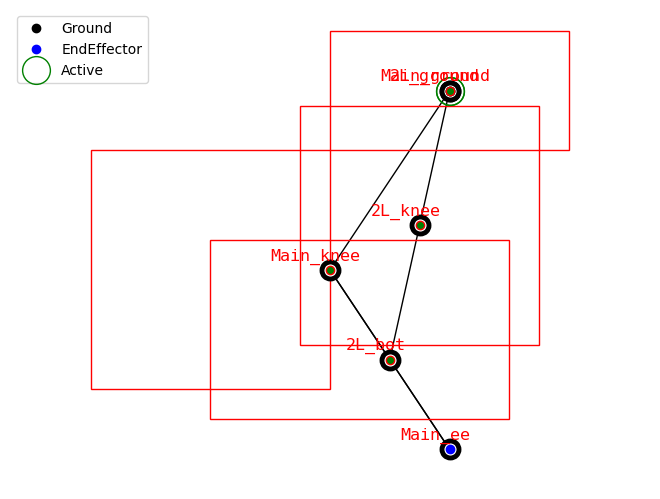

In [3]:
generator = TwoLinkGenerator()
all_graphs = generator.get_standard_set(-0.15, shift=0)
graph, constrain_dict = all_graphs[0]

thickness = MIT_CHEETAH_PARAMS_DICT["thickness"]
actuator = MIT_CHEETAH_PARAMS_DICT["actuator"]
density = MIT_CHEETAH_PARAMS_DICT["density"]
body_density = MIT_CHEETAH_PARAMS_DICT["body_density"]


builder = ParametrizedBuilder(DetailedURDFCreatorFixedEE,
                            density={"default": density, "G":body_density},
                            thickness={"default": thickness, "EE":0.033},
                            actuator={"default": actuator},
                            size_ground=np.array(MIT_CHEETAH_PARAMS_DICT["size_ground"]),
                            offset_ground=MIT_CHEETAH_PARAMS_DICT["offset_ground_rl"]
)
optimizing_joints = get_optimizing_joints(graph, constrain_dict)
draw_joint_point(graph)
visualize_constrains(graph, constrain_dict)

In [4]:
def mutate_JP_by_xopt(graph, x_opt, opt_joints):
    num_params_one_jp = len(x_opt) // len(opt_joints)

    for id, jp in zip(range(0, len(x_opt), num_params_one_jp), opt_joints):
        xz = x_opt[id: (id + num_params_one_jp)]
        list_nodes = list(graph.nodes())
        id = list_nodes.index(jp)
        list_nodes[id].r = np.array([xz[0], 0, xz[1]])

In [5]:
sampled_values, class_vector = KinematicDataset(graph,  builder, optimizing_joints, error_key="error",error_threshold=1e-5, isotropic_threshold=60).sample_and_rank(sample_size = 200,ranking_step=0.02,max_ranking_steps=9)


In [6]:
# Save the arrays to a .npz file
np.savez_compressed('dataset_rank_9_step_002_02k_wosing.npz', values=sampled_values, classes=class_vector)

In [7]:
import numpy as np

# Load the dataset
data = np.load('dataset_rank_9_step_002_01k.npz')
X = data['values']
y = data['classes']


In [8]:
import matplotlib.pyplot as plt
from matplotlib  import cm

def prepare_data_to_visualize_separeate_jps(data):
    """
    Prepare data to visualize
    """

    num_features = len(data[0]) // 4

    features = []
    for id in range(0, len(data[0]), num_features):
        features.append(data[:,id:id+num_features])
    
    # Return data to visualize
    return features

features = prepare_data_to_visualize_separeate_jps(X)


0


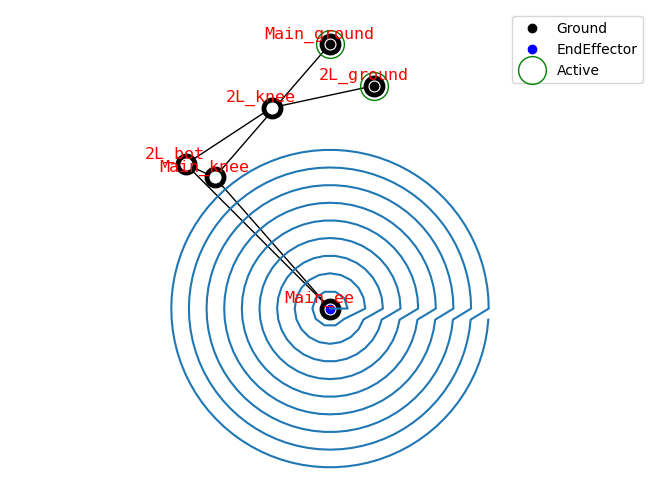

In [27]:
from copy import deepcopy
i = 10
mutable_graph=deepcopy(graph)
mutate_JP_by_xopt(mutable_graph, X[i], list(optimizing_joints.keys()))
draw_joint_point(mutable_graph)
print(y[i])
plt.plot(workspace_trajectory[:, 0], workspace_trajectory[:, 2])
plt.show()

In [18]:
fixed_robot, free_robot = jps_graph2pinocchio_robot(
            mutable_graph, builder)
dict_point_criteria = {
    "Manip_Jacobian": ManipJacobian(MovmentSurface.XZ)}
dict_trajectory_criteria = {}
crag = CriteriaAggregator(
    dict_point_criteria, dict_trajectory_criteria)

point_criteria_vector, trajectory_criteria, res_dict_fixed = crag.get_criteria_data(
    fixed_robot, free_robot, workspace_trajectory)

In [24]:
list(res_dict_fixed.keys())


['J_closed', 'M', 'dq', 'traj_6d_ee', 'traj_6d', 'error']

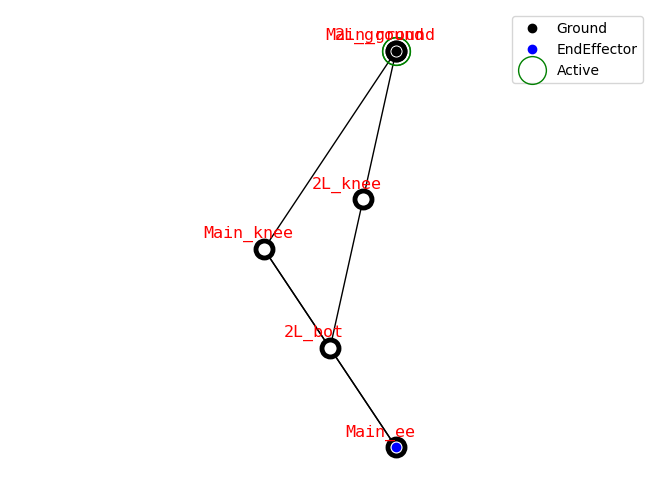

In [10]:
draw_joint_point(graph)

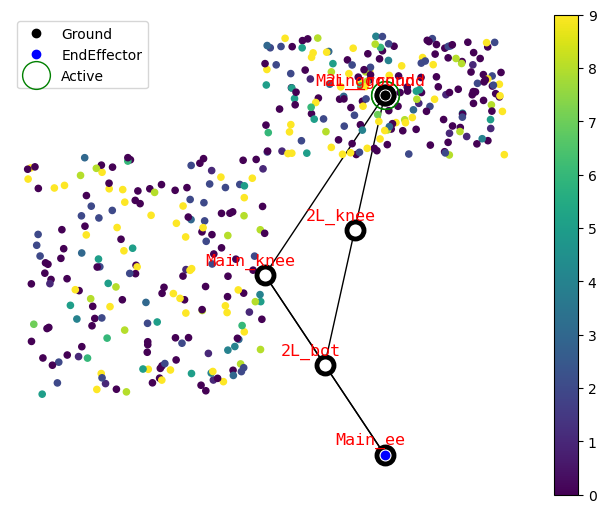

In [11]:
draw_joint_point(graph)
plt.scatter(features[0][:,0],features[0][:,1],s=20,c=y, marker = 'o' )
plt.scatter(features[1][:,0],features[1][:,1],s=20,c=y, marker = 'o' )

plt.colorbar()

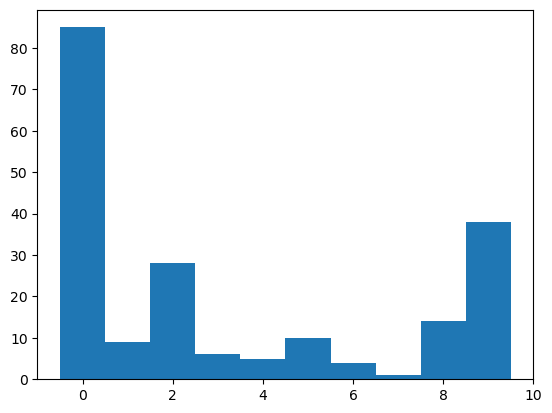

In [12]:
import matplotlib.pyplot as plt
np_hist = np.histogram(y, bins = 10,range=(-0.5, 9.5))
plt.stairs(np_hist[0], edges = np_hist[1], fill=True)

In [3]:
import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler


# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Custom dataset class
class CustomDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# Create datasets and data loaders
train_dataset = CustomDataset(X_train, y_train)
test_dataset = CustomDataset(X_test, y_test)

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Define and train your model (example)
import torch.nn as nn
import torch.optim as optim

class SimpleNN(nn.Module):
    def __init__(self, input_dim):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(input_dim, 16)
        self.fc2 = nn.Linear(16, 128)
        self.fc3 = nn.Linear(128, 256)
        self.fc4 = nn.Linear(256, 21)   
    
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        x = self.fc4(x)
        return x

input_dim = X_train.shape[1]
model = SimpleNN(input_dim)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 100

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(train_loader)}")

# Evaluate the model
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy: {100 * correct / total}%')

Epoch 1/100, Loss: 1.9451349396705628
Epoch 2/100, Loss: 1.6838105392456055
Epoch 3/100, Loss: 1.6112226023674012
Epoch 4/100, Loss: 1.5678200178146362
Epoch 5/100, Loss: 1.5259004945755006
Epoch 6/100, Loss: 1.4590215353965759
Epoch 7/100, Loss: 1.3645256743431091
Epoch 8/100, Loss: 1.2780455853939057
Epoch 9/100, Loss: 1.2353540844917297
Epoch 10/100, Loss: 1.199746796131134
Epoch 11/100, Loss: 1.1774350666999818
Epoch 12/100, Loss: 1.153666421175003
Epoch 13/100, Loss: 1.138496651172638
Epoch 14/100, Loss: 1.1297814588546753
Epoch 15/100, Loss: 1.1124764819145203
Epoch 16/100, Loss: 1.1056279799938202
Epoch 17/100, Loss: 1.1031883499622346
Epoch 18/100, Loss: 1.0978185360431671
Epoch 19/100, Loss: 1.0811499314308166
Epoch 20/100, Loss: 1.0840783252716064
Epoch 21/100, Loss: 1.0674802577495575
Epoch 22/100, Loss: 1.0663289818763733
Epoch 23/100, Loss: 1.0601129446029662
Epoch 24/100, Loss: 1.061196280479431
Epoch 25/100, Loss: 1.0513468430042268
Epoch 26/100, Loss: 1.0475044991970062